# Importing Libraries

In [1]:
!pip install --upgrade tensorflow --quiet
!pip install matplotlib --quiet

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Importing Images

In [3]:
SIZE = 256
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Corals",
    shuffle=True,
    image_size = (SIZE,SIZE),
    batch_size = BATCH_SIZE
)

len(dataset)

Found 11219 files belonging to 2 classes.


351

In [4]:
class_names = dataset.class_names
class_names

['bleached_corals', 'healthy_corals']

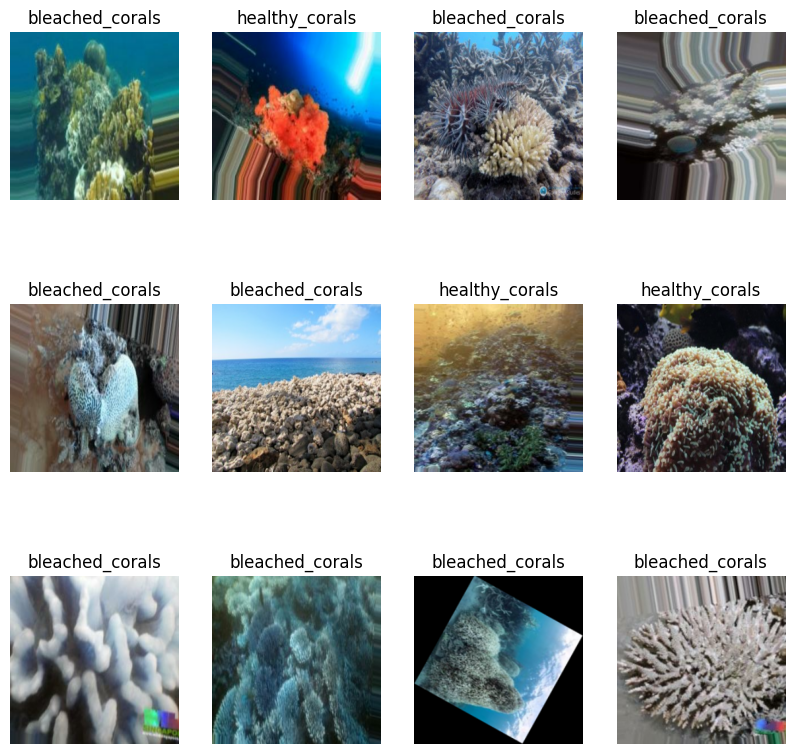

In [5]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

# Splitting data into Training, Validation and Test Sets:

80% ==> training 20% ==> 10% validation, 10% test

In [6]:
dataset = dataset.shuffle(10000,seed=13)

# Training Dataset
train_size = 0.8
s = int(len(dataset) * train_size)
train = dataset.take(s)
print(len(train))

test = dataset.skip(s)

# Validation Dataset
val_size = 0.1
s1 = int(len(dataset) * val_size)
valid = test.take(s1)
print(len(valid))

# Test Dataset
test = test.skip(s1)
print(len(test))

280
35
36


In [7]:
# Optimize the performance of model
train = train.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
valid = valid.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

# Pre-Processing and Data Augmentation

In [8]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(SIZE, SIZE),
    tf.keras.layers.Rescaling(1./255)
])

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Model Building

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

def attention_mechanism(inputs):
    # Flatten spatial dimensions, keeping channels separate
    shape = tf.shape(inputs)
    flattened_inputs = layers.Reshape((shape[1] * shape[2], shape[3]))(inputs)  # Reshaping to (batch_size, height*width, channels)
    
    # Dense layer for attention scores
    attention_weights = layers.Dense(units=1, activation="sigmoid")(flattened_inputs)  # Output shape: (batch_size, height*width, 1)
    attention_weights = layers.Reshape((-1,))(attention_weights)  # Flatten to (batch_size, height*width)
    attention_weights = layers.Softmax(axis=1)(attention_weights)  # Apply softmax to get normalized weights

    # Apply the attention weights to the flattened input
    attention_output = layers.Dot(axes=[1, 1])([attention_weights, flattened_inputs])  # Dot product to get weighted sum
    attention_output = layers.Reshape((shape[1], shape[2], shape[3]))(attention_output)  # Reshape back to original feature map shape
    
    return attention_output

SIZE = 256
BATCH_SIZE = 32

inputs = layers.Input(shape=(SIZE, SIZE, 3))

x = resize_and_rescale(inputs)
x = augmentation(x)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Apply attention mechanism
x = attention_mechanism(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train, epochs=100, batch_size=BATCH_SIZE, validation_data=valid)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 314s 947ms/step - accuracy: 0.6291 - loss: 0.6322 - val_accuracy: 0.7205 - val_loss: 0.5283
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 207s 736ms/step - accuracy: 0.7202 - loss: 0.5393 - val_accuracy: 0.7214 - val_loss: 0.5286
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 213s 761ms/step - accuracy: 0.7362 - loss: 0.5096 - val_accuracy: 0.7366 - val_loss: 0.5157
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 202s 721ms/step - accuracy: 0.7513 - loss: 0.4947 - val_accuracy: 0.7518 - val_loss: 0.4894
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 200s 715ms/step - accuracy: 0.7606 - loss: 0.4866 - val_accuracy: 0.7223 - val_loss: 0.5115
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 199s 710ms/step - accuracy: 0.7412 - loss: 0.4925 - val_accuracy: 0.7696 - val_loss: 0.4595
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 200s 715ms/step - accuracy: 0.7580 - loss: 0.4769 - val_accuracy: 0.7563 - val_loss: 0.4989
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 201s 716ms/step - accuracy: 

In [10]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy with attention: {test_accuracy * 100:.2f}%")

36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.9183 - loss: 0.2379
Test accuracy with attention: 92.97%


In [11]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 256, 256, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 256, 256, 3)       │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 254, 254, 32)      │             896 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 127, 127, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 125, 125, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 62, 62, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 60, 60, 64)        │          36,928 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 30, 30, 64)        │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 64)                │               0 │ max_pooling2d_2[0][0]      │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 64)                │               0 │ max_pooling2d_2[0][0]      │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 64)          │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 1, 1, 64)          │               0 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1, 1, 128)         │               0 │ reshape[0][0],             │
│                               │                           │                 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 1, 1, 1)           │             12

 Total params: 503,243 (1.92 MB)

 Trainable params: 167,747 (655.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 335,496 (1.28 MB)

# Plotting Accuracy and Loss Curves

In [12]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

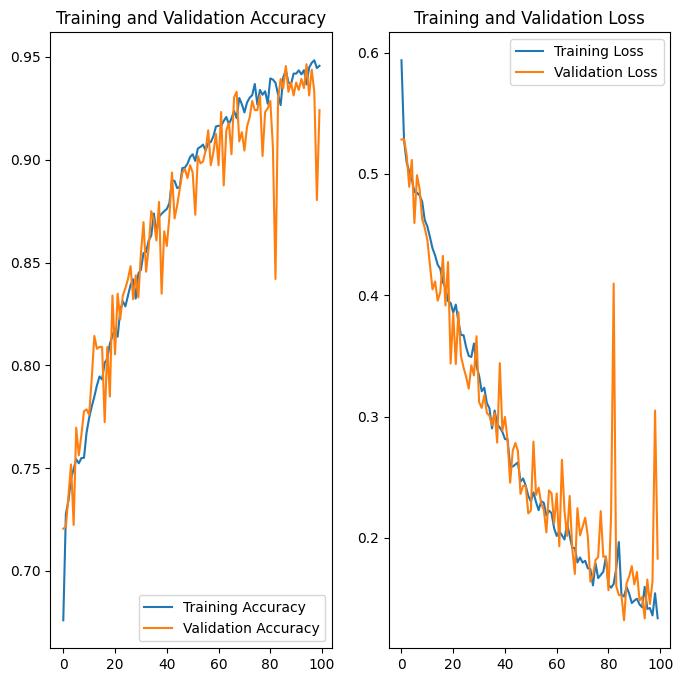

In [14]:
epochs = len(acc) 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Prediction

In [ ]:
for image_batch , label_batch in dataset.take(1):
  # plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("First Image to predict")
    plt.imshow(first_image)
    print("First Image's actual Label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    fclass = class_names[np.argmax(batch_prediction[0])]
    print(fclass)

# Saving the Model

In [2]:
model.save('CNNA.keras')